# Slippage Analysis

In [3]:
# Import necessary modules and functions
from web3 import Web3, HTTPProvider
import requests
from requests.exceptions import ConnectionError, Timeout, RequestException, HTTPError
from typing import Dict, Any, Optional
from datetime import datetime, timedelta
import time
import itertools
from dataclasses import dataclass
from icecream import ic
import numpy as np
import pandas as pd
import sys
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt


- Loads environment variables using `dotenv`
- Retrieves API keys for Etherscan and Alchemy

In [4]:
# Load environment variables
load_dotenv()

# Get Etherscan API key from environment variables
ETHERSCAN_API_KEY = os.getenv("ETHERSCAN_KEY")
ALCHEMY_KEY = os.getenv("ALCHEMY_KEY_2")

- Implements `build_url()` function to construct API URLs for different blockchain networks
- Supports networks: 'eth', 'arb', 'opt', 'base'
- Raises a `ValueError` for unsupported networks

In [5]:
VALID_NETWORKS = ['eth', 'arb', 'opt', 'base']

def build_url(network: str) -> str:

    # Check if the provided network is valid
    if network not in VALID_NETWORKS:
        raise ValueError(f"Invalid network: '{network}'. Supported networks are: {', '.join(VALID_NETWORKS)}")
    
    # Return the constructed URL if the network is valid
    return f"https://{network}-mainnet.g.alchemy.com/v2/{ALCHEMY_KEY}"



- Defines `query_token_supply()` function to fetch total supply of a token from a smart contract
- Uses Web3 to interact with the blockchain
- Handles potential errors during the query process


In [6]:
def query_token_supply(network, contract_address, *args, block_number=None):
    """
    Query a smart contract function.

    :param w3: Web3 instance
    :param contract_address: Address of the smart contract
    :param abi: ABI of the smart contract
    :param function_name: Name of the function to query
    :param args: Arguments to pass to the function (if any)
    :param block_number: Specific block number to query (optional)
    :return: Result of the function call or an error message
    """
    
    w3 = Web3(HTTPProvider(build_url(network)))
    abi = [{"inputs":[],"name":"totalSupply","outputs":[{"internalType":"uint256","name":"","type":"uint256"}],"stateMutability":"view","type":"function"}]
    function_name = "totalSupply"
    
    try:
        # Create contract instance
        contract = w3.eth.contract(address=Web3.to_checksum_address(contract_address), abi=abi)
        
        # Get the contract function
        contract_function = getattr(contract.functions, function_name)
        
        # Call the function with arguments and block identifier if provided
        if block_number is not None:
            data = contract_function(*args).call(block_identifier=int(block_number))
        else:
            data = contract_function(*args).call()
        
        return data
    
    except Exception as e:
        return f'Error querying smart contract: {e}'

- Defines `get_current_price()` function to retrieve the current price of a token
- Uses the Coin Llama API for price data
- Implements rate limiting exception handling

In [7]:
class RateLimitExceededException(Exception):
    """Exception raised for rate limit exceeded (429 Too Many Requests)."""
    def __init__(self, message: str, retry_after: Optional[int] = None):
        super().__init__(message)
        self.retry_after = retry_after

def get_current_price(token_address: str, network: str) -> Optional[float]:
    """
    Fetches the current price of a token from the Coin Llama API and extracts the price.

    Args:
        token_address (str): The address of the token.
        network (str): The network identifier (e.g., 'arbitrum').

    Returns:
        Optional[float]: The current price of the token or None if an error occurs.
    """
    base_url = "https://coins.llama.fi/prices/current"
    url = f"{base_url}/{network}:{token_address}?searchWidth=6h"

    # print(url)
    
    response = requests.get(url)
    if response.status_code == 429:
        retry_after = response.headers.get('Retry-After')
        raise RateLimitExceededException("Rate limit exceeded.", retry_after=int(retry_after) if retry_after else None)
    response.raise_for_status()  # Raise an exception for HTTP errors

    data = response.json()
    price_info = data.get('coins', {}).get(f'{network}:{token_address}', {})
    return price_info.get('price')

- Creates `chainDTO` class to store chain-related data
- Creates `TokenDTO` class to store token-related data
- Uses `@dataclass` decorator for efficient object creation

In [8]:
# Define chainDTO and TokenDTO classes
@dataclass(frozen=True, order=True)
class chainDTO:
    """
    Data Transfer Object to store relevant
    chain data.
    """
    network: str
    network_id: int
    id: str

@dataclass(frozen=True, order=True)
class TokenDTO:
    """
    Data Transfer Object to store relevant
    token data.
    """
    address: str
    name: str
    symbol: str
    decimals: int
    network: chainDTO
    supply: float
    price: float
    tvl: float
    # min_trade_size: float  # min amt_in for 1inch quotes
    # max_trade_size: float  # max amt_in for 1inch quotes

---

- Creates `chainDTO` objects for Optimism and Arbitrum networks
- Sets up a network mapping dictionary

In [9]:
######################### Chain Declaration ###############################

OPTIMISM_DTO = chainDTO(
    network="Optimism",
    network_id=10,
    id='opt'
    
) 

ARBITRUM_DTO = chainDTO(
    network="Arbitrum",
    network_id=42161,
    id='arb'
    
) 

network_mapping = {
    OPTIMISM_DTO.network_id: OPTIMISM_DTO,
    ARBITRUM_DTO.network_id: ARBITRUM_DTO
    # Add more chainDTO instances as needed
}


######################### Token Declaration ###############################

## Stables 

USDC_OP = "0x0b2C639c533813f4Aa9D7837CAf62653d097Ff85"
USDT_OP = "0x94b008aA00579c1307B0EF2c499aD98a8ce58e58"
DAI_OP = "0xDA10009cBd5D07dd0CeCc66161FC93D7c9000da1"

USDC_ARB = "0xaf88d065e77c8cC2239327C5EDb3A432268e5831"
USDT_ARB = "0xFd086bC7CD5C481DCC9C85ebE478A1C0b69FCbb9"
DAI_ARB= "0xDA10009cBd5D07dd0CeCc66161FC93D7c9000da1" # same



## Collateral 

WETH_OP = "0x4200000000000000000000000000000000000006"
WSTETH_OP = "0x1F32b1c2345538c0c6f582fCB022739c4A194Ebb"
WBTC_OP = "0x68f180fcCe6836688e9084f035309E29Bf0A2095"

WETH_ARB = "0x82aF49447D8a07e3bd95BD0d56f35241523fBab1"
WSTETH_ARB = "0x5979D7b546E38E414F7E9822514be443A4800529"
WBTC_ARB = "0x2f2a2543B76A4166549F7aaB2e75Bef0aefC5B0f"

- Implements `create_token_dto()` function to create `TokenDTO` objects
- Creates token objects for stablecoins and collateral assets on Optimism and Arbitrum


In [10]:
def create_token_dto(address, name, symbol, decimals, chainDTO):
    
    supply = query_token_supply(chainDTO.id, address)/pow(10, decimals)
    price = get_current_price(address, chainDTO.network.lower())
    tvl = supply * price
    
    return TokenDTO(
        address=address,
        name=name,
        symbol=symbol,
        decimals=decimals,
        network=chainDTO,
        supply=supply,
        price=price,
        tvl=tvl
    )

### Token Declaration ###

stables_opt = [
    create_token_dto(USDC_OP, "USD Coin (Optimism)", "USDC", 6, OPTIMISM_DTO),
    create_token_dto(USDT_OP, "Tether USD (Optimism)", "USDT", 6, OPTIMISM_DTO),
    create_token_dto(DAI_OP, "DAI Stablecoin (Optimism)", "DAI", 18, OPTIMISM_DTO)
]

collateral_opt = [
    create_token_dto(WETH_OP, "Wrapped Ether (Optimism)", "WETH", 18, OPTIMISM_DTO),
    create_token_dto(WSTETH_OP, "Wrapped liquid staked Ether 2.0 (Optimism)", "wstETH", 18, OPTIMISM_DTO),
    create_token_dto(WBTC_OP, "Wrapped BTC (Optimism)", "WBTC", 8, OPTIMISM_DTO)
]

stables_arb = [
    create_token_dto(USDC_ARB, "USD Coin (Arbitrum)", "USDC", 6, ARBITRUM_DTO),
    create_token_dto(USDT_ARB, "Tether USD (Arbitrum)", "USDT", 6, ARBITRUM_DTO),
    create_token_dto(DAI_ARB, "DAI Stablecoin (Arbitrum)", "DAI", 18, ARBITRUM_DTO)
]

collateral_arb = [
    create_token_dto(WETH_ARB, "Wrapped Ether (Arbitrum)", "WETH", 18, ARBITRUM_DTO),
    create_token_dto(WSTETH_ARB, "Wrapped liquid staked Ether 2.0 (Arbitrum)", "wstETH", 18, ARBITRUM_DTO),
    create_token_dto(WBTC_ARB, "Wrapped BTC (Arbitrum)", "WBTC", 8, ARBITRUM_DTO)
]


- Defines `kyberswap_get_quote()` function to fetch swap quotes from KyberSwap API
- Defines `paraswap_get_quote()` function to fetch swap quotes from ParaSwap API
- Both functions handle API interactions, error handling, and data formatting


These functions fetch swap quotes from KyberSwap and ParaSwap APIs, respectively.

### Common parameters for both functions:
• `src_token`: Address of the source token
• `src_decimals`: Decimal places of the source token
• `dest_token`: Address of the destination token
• `dest_decimals`: Decimal places of the destination token
• `usd_amount`: Amount in USD to swap
• `market_price`: Current market price of the source token
• `network_id`: ID of the network (e.g., Arbitrum, Optimism)

### KyberSwap function:
- Constructs the API URL and parameters for KyberSwap
- Sends a GET request to the KyberSwap API
- Processes the response to extract relevant data (amounts, prices, impact)

### ParaSwap function:
- Constructs the API URL and parameters for ParaSwap
- Sends a GET request to the ParaSwap API
- Processes the response to extract relevant data (amounts, prices, impact)

### Common features:
- Both functions calculate and return:
  • Network ID
  • Aggregator name
  • Token addresses and decimals
  • Input and output amounts
  • Market price and execution price
  • Price impact
  • Timestamp

- Error handling:
  • Catches and reports various exceptions (ConnectionError, Timeout, RequestException)
  • Returns error information if the API call fails

In [11]:
def kyberswap_get_quote(
    src_token: str, 
    src_decimals: int, 
    dest_token: str, 
    dest_decimals: int, 
    usd_amount: float, 
    market_price: float,
    network_id: int
) -> Dict[str, Any]:
    """
    Fetches the swap rate between two tokens using the KyberSwap API.

    Args:
        src_token (str): The address of the source token.
        src_decimals (int): The number of decimals for the source token.
        dest_token (str): The address of the destination token.
        dest_decimals (int): The number of decimals for the destination token.
        usd_amount (float): The amount of USD to swap.
        market_price (float): The current market price of the source token.
        network (str): The network identifier (e.g., '42161' for Arbitrum).

    Returns:
        Dict[str, Any]: A dictionary containing the response from the KyberSwap API or an error message.
    """

    network = network_mapping[network_id].network.lower()
    api_url = f"https://aggregator-api.kyberswap.com/{network}/api/v1/routes"

    # Calculate the amount of the source token to swap


    # Construct the request parameters
    params = {
        "tokenIn": src_token,
        "amountIn":  int((usd_amount / market_price) * (10 ** src_decimals)),
        "tokenOut": dest_token,
    }

    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json",
    }

    try:
        # Make the API request
        response = requests.get(api_url, headers=headers, params=params)
        response.raise_for_status()  # Raise an exception for HTTP errors

        if response.status_code == 200:
            quote_raw = response.json()

            # extract
            src_amount = float(quote_raw['data']['routeSummary']['amountIn'])
            dest_amount = float(quote_raw['data']['routeSummary']['amountOut'])
            src_usd = float(quote_raw['data']['routeSummary']['amountInUsd']) 
            dest_usd = float(quote_raw['data']['routeSummary']['amountOutUsd']) 
            aggregator = str('kyberswap')

            # format row 
            row = {
                "network": network_id,
                "dex_aggregator": aggregator, 
                "src": src_token,
                "src_decimals": src_decimals,
                "dst": dest_token,
                "dest_decimals": dest_decimals,
                "in_amount_usd": usd_amount,
                "in_amount": src_amount, 
                "out_amount": dest_amount,
                "market_price": market_price, 
                "price": (src_amount/(10**src_decimals)) / (dest_amount/(10**dest_decimals)), #execution_price
                "price_impact": (src_usd-dest_usd) / src_usd, #impact_cost
                "timestamp": round((datetime.now() + timedelta(minutes=30)).replace(minute=0, second=0, microsecond=0).timestamp())
            }

            # print(row)

            return row

    except ConnectionError as ce:
        print(f"Connection error: {ce}")
        return {"error": "ConnectionError", "message": str(ce)}
    except Timeout as te:
        print(f"Timeout error: {te}")
        return {"error": "TimeoutError", "message": str(te)}
    except RequestException as re:
        print(f"Request exception: {re}")
        return {"error": "RequestException", "message": str(re)}
    except Exception as e:
        print(f"Unexpected error: {e}")
        return {"error": "UnexpectedError", "message": str(e)}
    
def paraswap_get_quote(
    src_token: str, 
    src_decimals: int, 
    dest_token: str, 
    dest_decimals: int, 
    usd_amount: float, 
    market_price: float,
    network_id: int
) -> Dict[str, Any]:
    """
    Fetches the swap rate between two tokens using the ParaSwap API.

    Args:
        src_token (str): The address of the source token.
        src_decimals (int): The number of decimals for the source token.
        dest_token (str): The address of the destination token.
        dest_decimals (int): The number of decimals for the destination token.
        amount (float): The amount of the source token to swap.
        network (str): The network identifier (e.g., '1' for Ethereum Mainnet).

    Returns:
        Dict[str, Any]: A dictionary containing the response from the ParaSwap API or an error message.

    For more details refer to: https://developers.paraswap.network/api/get-rate-for-a-token-pair-1
    """
    api_url = "https://api.paraswap.io/swap"

    # Construct the request parameters
    params = {
        "userAddress": "0x3727cfCBD85390Bb11B3fF421878123AdB866be8",
        "srcToken": src_token,
        "srcDecimals": src_decimals,
        "destToken": dest_token,
        "destDecimals": dest_decimals,
        "amount": f"{int((usd_amount/market_price) * (10 ** src_decimals))}",
        "side": "SELL",
        "network": str(network_id),
        "slippage": 9999,  # 100% slippage tolerance
        "maxImpact": 100
    }

    try:
        # Make the API request
        response = requests.get(api_url, params=params)
        response.raise_for_status()  # Raise an exception for HTTP errors

        if 'priceRoute' in response.json():

            quote_raw = response.json()['priceRoute']

            # extract
            src_amount = float(quote_raw['srcAmount'])
            dest_amount = float(quote_raw['destAmount'])
            src_usd = float(quote_raw['srcUSD'])
            dest_usd = float(quote_raw['destUSD'])
            aggregator = str('paraswap')

            # format row 

            row = {
                    "network": network_id,
                    "dex_aggregator": aggregator, 
                    "src": src_token,
                    "src_decimals": src_decimals,
                    "dst": dest_token,
                    "dest_decimals": dest_decimals,
                    "in_amount_usd": usd_amount,
                    "in_amount": src_amount, 
                    "out_amount": dest_amount,
                    "market_price": market_price, 
                    "price": (src_amount/(10**src_decimals)) / (dest_amount/(10**dest_decimals)), #execution_price"
                    "price_impact": (src_usd-dest_usd) / src_usd, #impact_cost
                    "timestamp": round((datetime.now() + timedelta(minutes=30)).replace(minute=0, second=0, microsecond=0).timestamp())
                }

            # print(row)

            return row

    except ConnectionError as ce:
        print(f"Connection error: {ce}")
        return {"error": "ConnectionError", "message": str(ce)}
    except Timeout as te:
        print(f"Timeout error: {te}")
        return {"error": "TimeoutError", "message": str(te)}
    except RequestException as re:
        print(f"Request exception: {re}")
        return {"error": "RequestException", "message": str(re)}
    except Exception as e:
        print(f"Unexpected error: {e}")
        return {"error": "UnexpectedError", "message": str(e)}

- Implements `create_permutations()` function to generate all possible token swap pairs
- Creates permutations between stablecoins and collateral tokens


In [12]:
import itertools

# Create permutations between stables_arb and collateral_arb
def create_permutations(stables, collaterals):
    # Generate permutations: one from stables, one from collateral, and vice versa
    permutations = []
    
    # stables_arb -> collateral_arb
    for stable, collateral in itertools.product(stables, collaterals):
        permutations.append((stable, collateral))
    
    # collateral_arb -> stables_arb
    for collateral, stable in itertools.product(collaterals, stables):
        permutations.append((collateral, stable))
    
    return permutations


- Defines `paraswap_job()` function to:

  • Generate asset permutations

  • Fetch quotes for various amounts

  • Process and store quote data
  
- Implements early stopping criteria and rate limiting

This function is the main driver for fetching and processing swap quotes across multiple token pairs and amounts.

- Parameters:
  • `stable_tokens`: List of stable token objects
  • `collateral_tokens`: List of collateral token objects
  • `num_samples`: Number of price samples to fetch (default: 30)

- Key steps:
  1. Initialization:
     • Sets up stopping criteria and result storage
     • Generates asset permutations using `create_permutations()`

  2. Iteration over token pairs:
     • For each token pair, calculates start and end amounts based on token TVLs
     • Generates a logarithmically spaced range of amounts

  3. Quote fetching:
     • For each amount, fetches quotes from both ParaSwap and KyberSwap
     • Uses `paraswap_get_quote()` and `kyberswap_get_quote()` functions
     • Implements error handling and rate limiting

  4. Data storage:
     • Stores fetched quotes in a list of dictionaries

  5. Early stopping:
     • Implements an early stopping mechanism (logic not fully visible in the snippet)

- Return value:
  • Pandas DataFrame containing all fetched quotes and computed metrics


In [13]:
def paraswap_job(
        stable_tokens,
        collateral_tokens,
        # start_amount = 100,
        # end_amount = 50_000_100,
        num_samples = 30,
    ):

    stopping_criteria = 0 
    new_rows_list = []
    
    
    # Generate asset permutations for a given network 
    asset_permutations = create_permutations(stable_tokens, collateral_tokens)

    # Iterate over each permutation
    for permutation in asset_permutations:
        
        # Add a print statement to check the permutation
        print(f"Building Permutation: {permutation[0].symbol} -> {permutation[1].symbol}")
        
        sell_token = permutation[0]
        buy_token = permutation[1]

        # Fetch sell token price 
        price = sell_token.price
        
        start_amount = min(sell_token.tvl, buy_token.tvl) * 0.001 # 0.1% of the smaller token's TVL
        end_amount = min(sell_token.tvl, buy_token.tvl) * 0.7 # 70% of the smaller token's TVL
        amounts = np.geomspace(start_amount, end_amount, num=num_samples).astype(int).tolist()

        # Iterate through the generated amounts and fetch quotes
        for amount in amounts:

            # Add a print statement to check the amount
            print(f"Fetching Quotes[{sell_token.symbol} -> {buy_token.symbol}] || Amount: {amount}")
            try:                
                new_row = paraswap_get_quote(
                    src_token=sell_token.address, 
                    src_decimals=sell_token.decimals, 
                    dest_token=buy_token.address, 
                    dest_decimals=buy_token.decimals, 
                    usd_amount=amount, 
                    market_price=price,
                    network_id=sell_token.network.network_id
                )

                new_row2 = kyberswap_get_quote(
                    src_token=sell_token.address, 
                    src_decimals=sell_token.decimals, 
                    dest_token=buy_token.address, 
                    dest_decimals=buy_token.decimals, 
                    usd_amount=amount, 
                    market_price=price,
                    network_id=sell_token.network.network_id
                )

                # new_row is a dictionary, create a list of dictionaries and append new_row to new_rows_list
                new_rows_list.append(new_row)
                new_rows_list.append(new_row2)

            except Exception as e:
                print(f"Failed to save entry to DB: {e}")

            # Early stopping criteria 
            if stopping_criteria > 0.99: 
                break
            else:
                # Sleep for a short duration to avoid hitting the rate limit of the API
                time.sleep(1.1)  # Adjust the sleep duration if necessary
    
    # convert new_rows_list to a pandas DataFrame
    df = pd.DataFrame(new_rows_list)
    return df

In [15]:
# Test paraswap_job function
dfp = paraswap_job(stable_tokens=stables_opt[0:1], collateral_tokens=collateral_opt)


Building Permutation: USDC -> WETH
Fetching Quotes[USDC -> WETH] || Amount: 88361
Fetching Quotes[USDC -> WETH] || Amount: 110756
Fetching Quotes[USDC -> WETH] || Amount: 138827
Fetching Quotes[USDC -> WETH] || Amount: 174012
Fetching Quotes[USDC -> WETH] || Amount: 218116
Fetching Quotes[USDC -> WETH] || Amount: 273397
Fetching Quotes[USDC -> WETH] || Amount: 342690
Fetching Quotes[USDC -> WETH] || Amount: 429545
Fetching Quotes[USDC -> WETH] || Amount: 538412
Fetching Quotes[USDC -> WETH] || Amount: 674873
Fetching Quotes[USDC -> WETH] || Amount: 845919
Fetching Quotes[USDC -> WETH] || Amount: 1060317
Fetching Quotes[USDC -> WETH] || Amount: 1329054
Fetching Quotes[USDC -> WETH] || Amount: 1665902
Fetching Quotes[USDC -> WETH] || Amount: 2088124
Fetching Quotes[USDC -> WETH] || Amount: 2617359
Fetching Quotes[USDC -> WETH] || Amount: 3280727
Fetching Quotes[USDC -> WETH] || Amount: 4112225
Fetching Quotes[USDC -> WETH] || Amount: 5154467
Fetching Quotes[USDC -> WETH] || Amount: 64608

In [16]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   network         360 non-null    int64  
 1   dex_aggregator  360 non-null    object 
 2   src             360 non-null    object 
 3   src_decimals    360 non-null    int64  
 4   dst             360 non-null    object 
 5   dest_decimals   360 non-null    int64  
 6   in_amount_usd   360 non-null    int64  
 7   in_amount       360 non-null    float64
 8   out_amount      360 non-null    float64
 9   market_price    360 non-null    float64
 10  price           360 non-null    float64
 11  price_impact    360 non-null    float64
 12  timestamp       360 non-null    int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 36.7+ KB


In [17]:
def plot_price_impact(dfp, src_token, dst_token):
    # Filter the dataframe for specific src and dst tokens
    df_src_dst = dfp[(dfp['src'] == src_token) & (dfp['dst'] == dst_token)]

    # Plot the dataframe in_amount_usd and price_impact
    plt.figure(figsize=(10, 6))

    # Create a color map for different aggregators
    color_map = {'kyberswap': 'blue', 'paraswap': 'red'}

    # Plot each aggregator with a different color
    for aggregator in df_src_dst['dex_aggregator'].unique():
        df_agg = df_src_dst[df_src_dst['dex_aggregator'] == aggregator]
        plt.scatter(df_agg['in_amount_usd'], df_agg['price_impact'], 
                    alpha=0.5, 
                    label=aggregator, 
                    color=color_map.get(aggregator, 'green'))  # 'green' as default color

    plt.xscale('log')
    plt.xlabel('USD Amount')
    plt.ylabel('Price Impact')
    plt.title(f'Price Impact vs. USD Amount for {src_token[:5]} -> {dst_token[:5]}')
    plt.legend()
    plt.show()

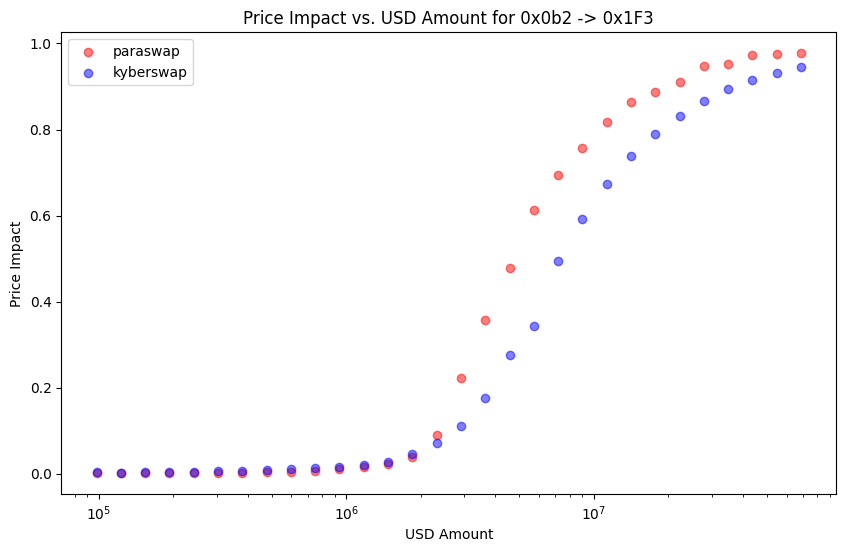

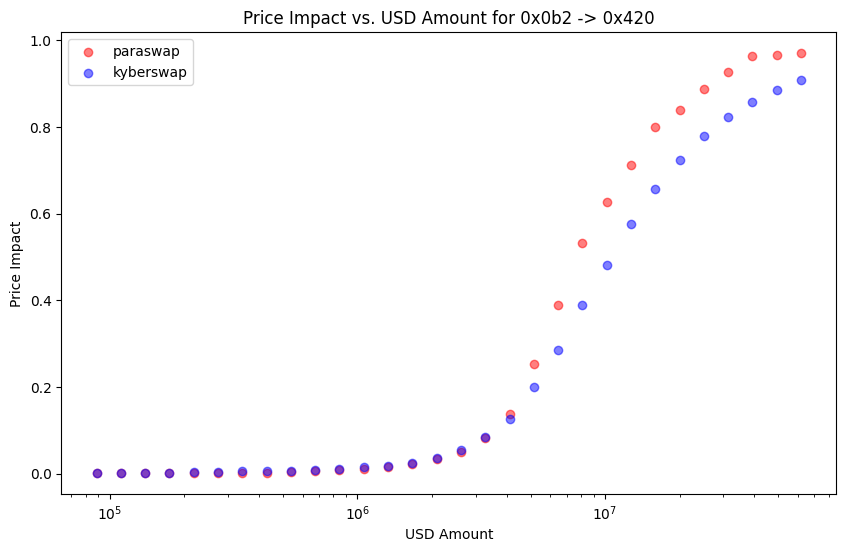

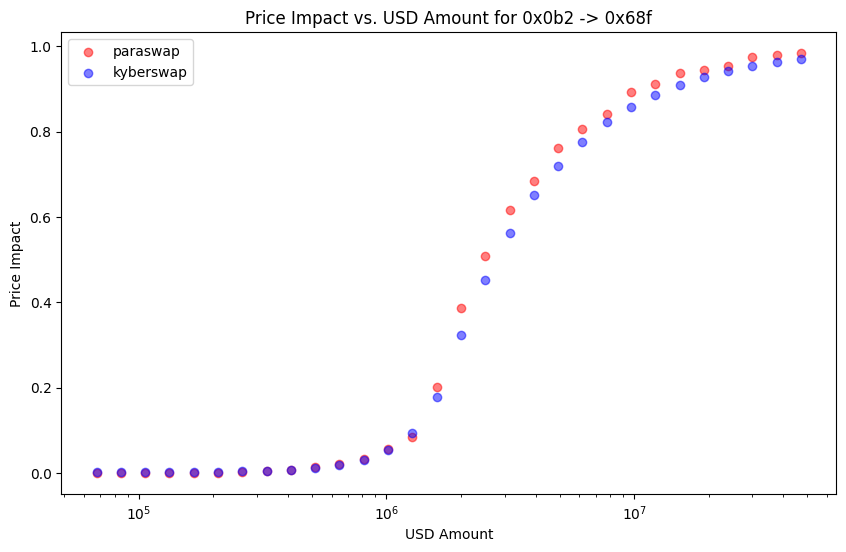

In [19]:
plot_price_impact(dfp, USDC_OP, WSTETH_OP)
plot_price_impact(dfp, USDC_OP, WETH_OP)
plot_price_impact(dfp, USDC_OP, WBTC_OP)

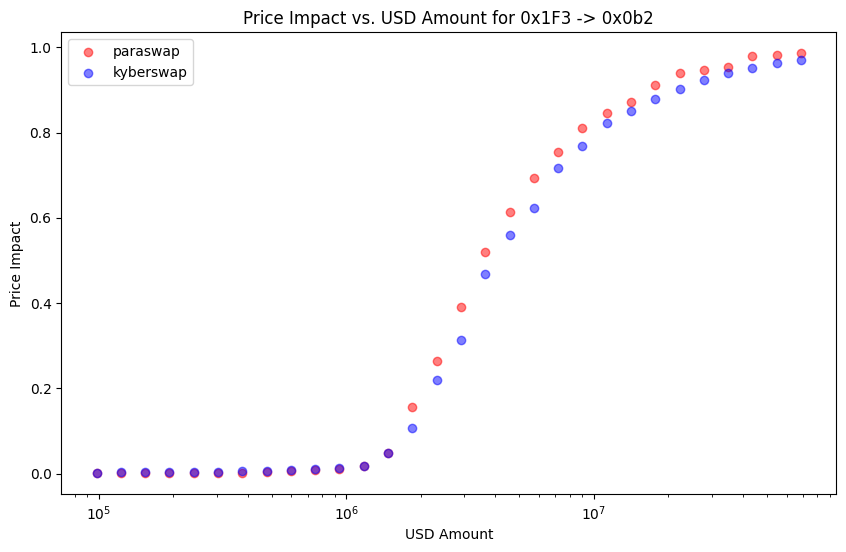

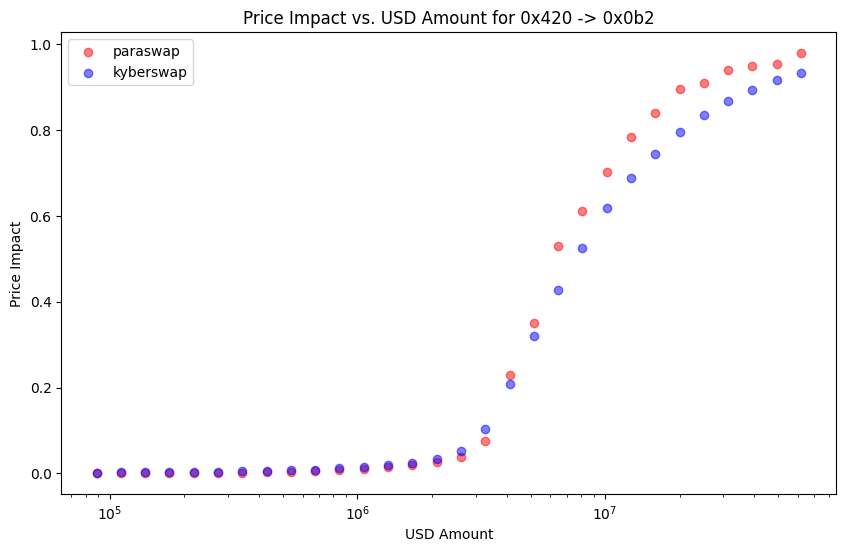

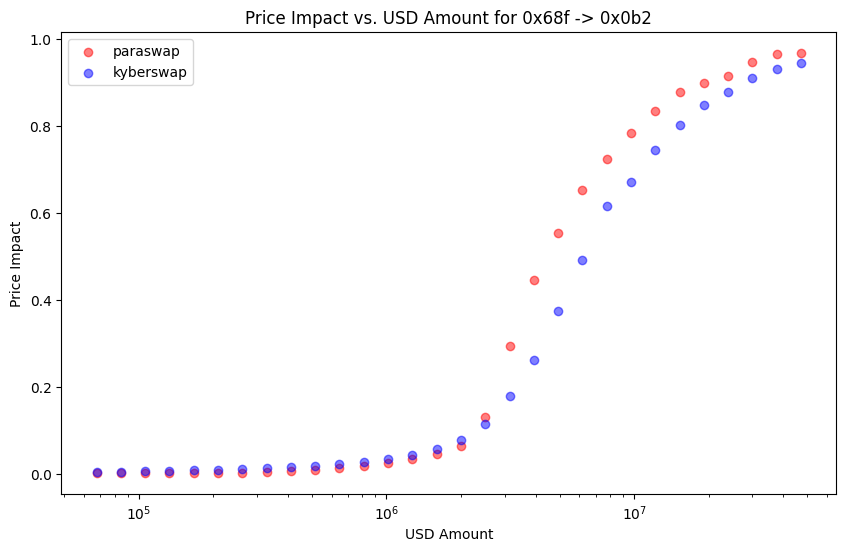

In [20]:
plot_price_impact(dfp, WSTETH_OP, USDC_OP)
plot_price_impact(dfp, WETH_OP, USDC_OP)
plot_price_impact(dfp, WBTC_OP, USDC_OP)

---

- Defines `modified_gompertz()` function for curve fitting
- Implements `fit_and_plot_gompertz2()` function to:

  • Fit the modified Gompertz function to the data

  • Plot the results

  • Calculate and display R-squared values
  
- Applies the curve fitting analysis to various token pairs



This function fits a modified Gompertz function to the price impact data and visualizes the results.

- Parameters:
  • `src_token`: Address of the source token
  • `dst_token`: Address of the destination token
  • `dfp`: DataFrame containing the price impact data (default: global `dfp`)

- Key steps:
  1. Data preparation:
     • Filters the DataFrame for the specific token pair and 'kyberswap' aggregator
     • Extracts 'in_amount_usd' and 'price_impact' data
     • Applies logarithmic transformation to 'in_amount_usd'

  2. Curve fitting:
     • Defines the modified Gompertz function: `f(x) = 1 * exp(-exp(b - c * x))`
     • Sets initial guess and bounds for parameters
     • Uses `scipy.optimize.curve_fit` to fit the function to the data

  3. Visualization:
     • Generates points for the fitted curve
     • Creates a scatter plot of the original data
     • Overlays the fitted curve on the plot
     • Uses logarithmic scale for the x-axis

  4. Statistical analysis:
     • Calculates and prints optimized parameters (b and c)
     • Computes and prints the R-squared value to assess goodness of fit

- Return value:
  • Tuple containing optimized parameters, covariance matrix, and R-squared value


In [35]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def modified_gompertz(x, b, c):
    return 1 * np.exp(-np.exp(b - c * x))

def fit_and_plot_gompertz2(src_token, dst_token, dfp=dfp):
    
    df_src_dst = dfp[(dfp['src'] == src_token) 
                     & (dfp['dst'] == dst_token) 
                     & (dfp['dex_aggregator'] == 'kyberswap')] 
    
    # Extract data from DataFrame
    x_data = df_src_dst['in_amount_usd'].values
    # print(x_data)
    y_data = df_src_dst['price_impact'].values

    # Apply logarithmic transformation to x_data
    x_data_log = np.log(x_data)
    # print(x_data_log)

    # Perform curve fitting
    initial_guess = [1.0, 1.0]  # [b, c]
    bounds = ([-np.inf, 0], [np.inf, np.inf])
    try:
        popt, pcov = curve_fit(modified_gompertz, x_data_log, y_data, p0=initial_guess, bounds=bounds)
    except RuntimeError:
        print("Error: Curve fit failed. Try adjusting the initial guess or check your data.")
        return None

    # Generate points for the fitted curve
    x_fit_log = np.linspace(min(x_data_log), max(x_data_log), 100)
    y_fit = modified_gompertz(x_fit_log, *popt)

    # Convert back to original scale for plotting
    x_fit = np.exp(x_fit_log)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
    plt.xscale('log')  # Use log scale for x-axis
    plt.legend()
    plt.xlabel('in_amount_usd')
    plt.ylabel('price_impact')
    plt.title('Modified Gompertz Function Fit (a=1)')

    # Print optimized parameters
    print(f"Optimized parameters: a = 1 (fixed), b = {popt[0]:.4f}, c = {popt[1]:.4f}")

    # Calculate R-squared
    y_pred = modified_gompertz(x_data_log, *popt)
    residuals = y_data - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"R-squared: {r_squared:.4f}")

    plt.show()

    return popt, pcov, r_squared

# Usage example:
# popt, pcov, r_squared = fit_and_plot_gompertz('src_token', 'dst_token', dfp)

Optimized parameters: a = 1 (fixed), b = 19.2827, c = 1.2878
R-squared: 0.9988


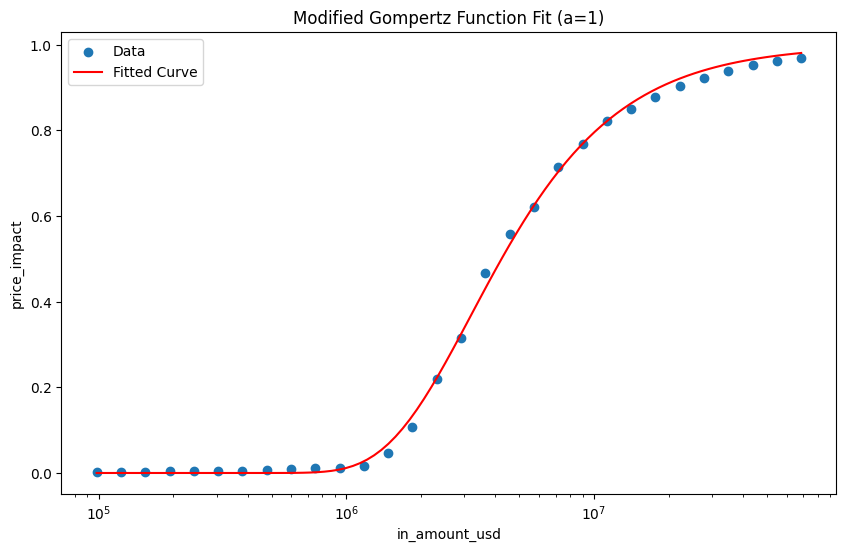

Optimized parameters: a = 1 (fixed), b = 19.0827, c = 1.2248
R-squared: 0.9990


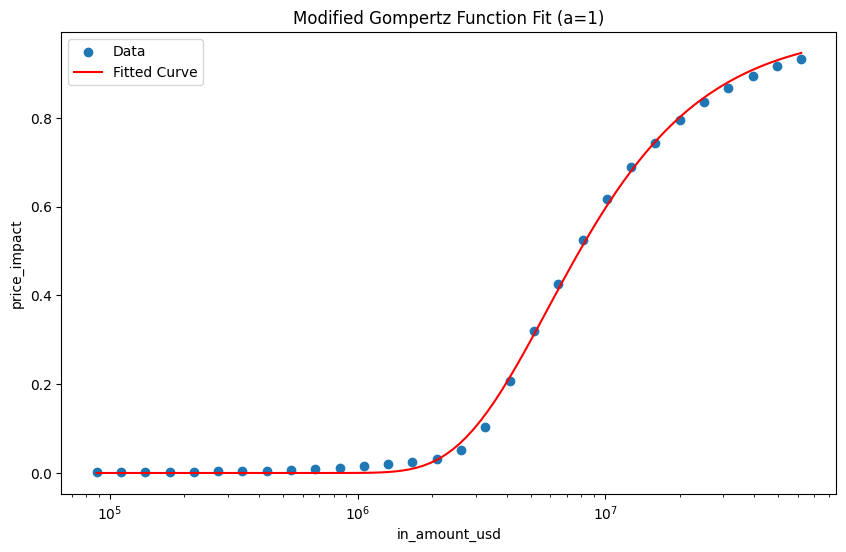

Optimized parameters: a = 1 (fixed), b = 19.4050, c = 1.2634
R-squared: 0.9976


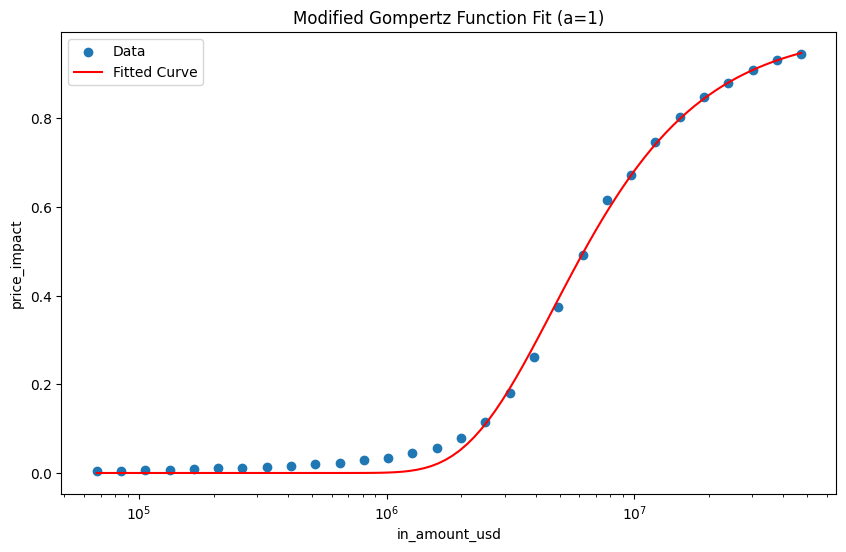

In [36]:
popt, pcov, r_squared = fit_and_plot_gompertz2(WSTETH_OP, USDC_OP)
popt, pcov, r_squared = fit_and_plot_gompertz2(WETH_OP, USDC_OP)
popt, pcov, r_squared = fit_and_plot_gompertz2(WBTC_OP, USDC_OP)

Optimized parameters: a = 1 (fixed), b = 18.9908, c = 1.2230
R-squared: 0.9987


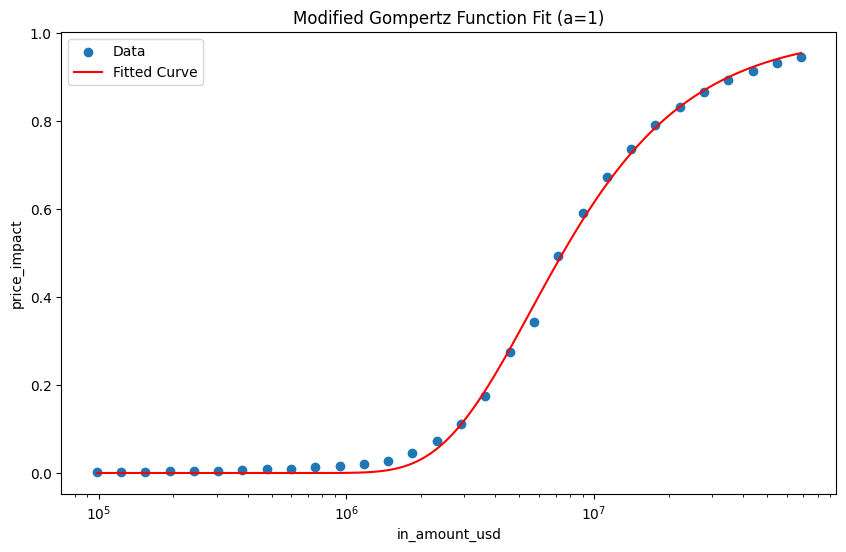

Optimized parameters: a = 1 (fixed), b = 18.0965, c = 1.1419
R-squared: 0.9991


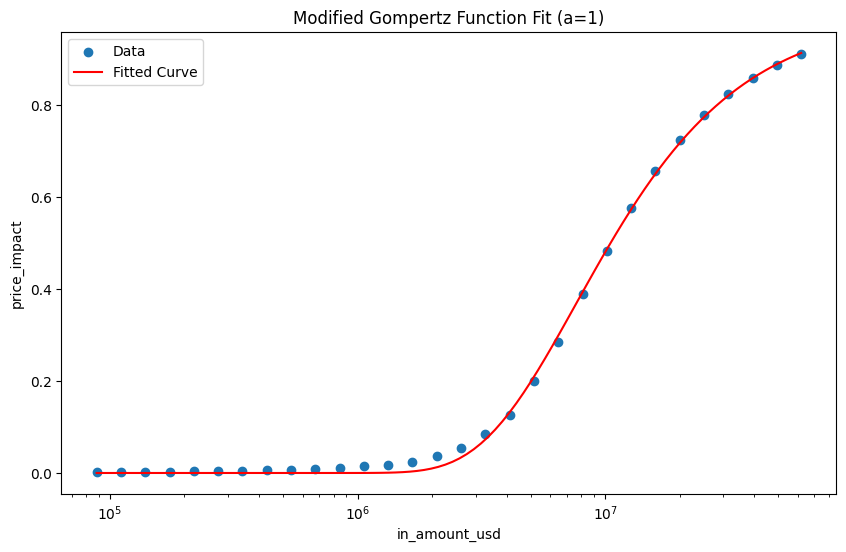

Optimized parameters: a = 1 (fixed), b = 19.5960, c = 1.3414
R-squared: 0.9986


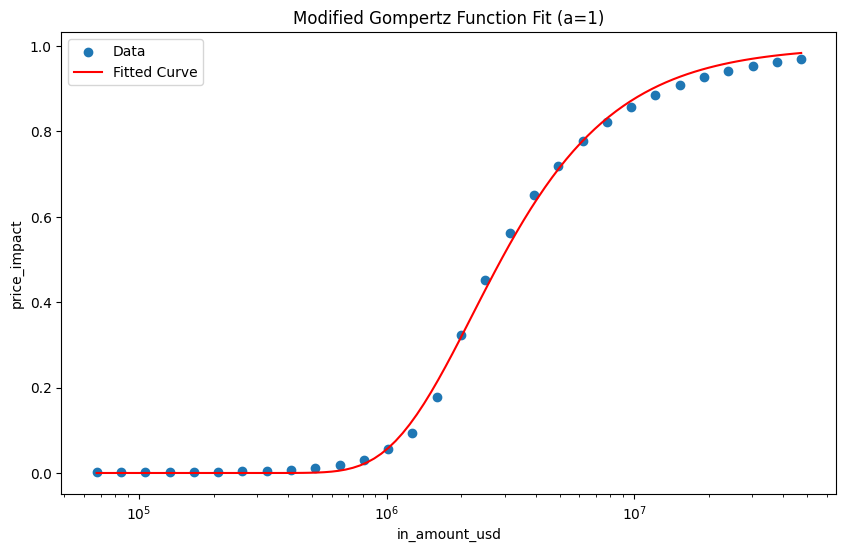

In [37]:
popt, pcov, r_squared = fit_and_plot_gompertz2(USDC_OP, WSTETH_OP)
popt, pcov, r_squared = fit_and_plot_gompertz2(USDC_OP, WETH_OP)
popt, pcov, r_squared = fit_and_plot_gompertz2(USDC_OP, WBTC_OP)

---